# Constraints Analysis

In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

***
## Introduction

CARPy provides users with the ability to constrain designs, using a flavour of Energy-manoeuvrability theory.
To make the best use of this concept, the following objects are introduced:

1. `Constraint`: The base constraint class that provides constraint analysis methods.
2. `Constraints`: A means of considering multiple constraints together and operating on them.
3. `Manoeuvre3DTW`: A type of design constraint for optimising thrust, based on Energy-manoeuvrability theory.
4. `Manoeuvre3DPW`: A type of design constraint for optimising power, based on Energy-manoeuvrability theory.

These objects are laid out in this way to facilitate future expansion of the constraint concept.

***
## 1) `Constraint` and 2) `Constraints` objects

We begin in a rather unorthodox manner - we introduce the generic types of `Constraint` and `Constraints`.
The purpose of these objects is to provide users with a convenient framework for defining a vehicle's mission in a regularised format.
They don't do anything by themselves when imported, but it's a good idea to learn about why they exist and what methods their children inherit.

### How the Python `class` types work

Whether you know it or not, `class`es are massively important to how Python works.
Some built-in classes can instantiate with clever bracket notation

In [2]:
# Bracket notation can make sets, dicts, lists, tuples, ...
my_shiny_new_list = [6, 2, 3]

def typeprint(var):
    print(f"Instance {var} came from the {type(var)}")

typeprint(my_shiny_new_list)

Instance [6, 2, 3] came from the <class 'list'>


But all classes can instantiate by calling the class name (provided you've imported it, if it wasn't built-in)

In [3]:
# Could create a tuple(), a set(), numpy.array(), etc.
my_new_tuple = tuple(my_shiny_new_list)

typeprint(my_new_tuple)

Instance (6, 2, 3) came from the <class 'tuple'>


In the above cases, `[6, 2, 3]` and `(6, 2, 3)` are instances of the `list` and `tuple` classes, respectively.
No matter what class you use, two things happen when you call a class to create an instance:

In [4]:
# Create a new class that inherits methods from the built-in list type
class MyClass(list):
    
    # __new__ decides what type of instance returns to the user
    def __new__(cls, *args, **kwargs):
        
        print("__new__ says \"Oranges\"")
        
        # Use the super().__new__(...) method to return the default
        # behaviour for __new__ that would have run without our changes
        instance = super().__new__(cls, *args, **kwargs)
        
        print(f"__new__ will return the empty instance: {instance}\n")
        
        return instance
    
    # __init__ takes the instance from __new__, and populates its attributes
    def __init__(self, *args, **kwargs):
        
        print("__init__ says \"Lemons\"")
        print(f"__init__ starts with __new__'s result: {self}")
        
        # Use the super().__init__(...) method to return the default
        # behaviour for __init__ that would have run without our changes
        super().__init__(*args, **kwargs)
        
        print(f"__init__ populated the instance as: {self}\n")
        return

# Create an instance of our new class
my_shiny_new_instance = MyClass([6, 2])

typeprint(my_shiny_new_instance)

__new__ says "Oranges"
__new__ will return the empty instance: []

__init__ says "Lemons"
__init__ starts with __new__'s result: []
__init__ populated the instance as: [6, 2]

Instance [6, 2] came from the <class '__main__.MyClass'>


### `Constraint` objects

`Constraint` (singular) overrides the `__new__` method so that it actually returns a `Constraints` (plural) object

```
def __new__(cls, **kwargs):
    constraint_objects = [...]
    ... 
    return Constraints(constraint_objects)
```

This means that even if you only mean to create a single constraint, you will receive an instance from `Constraints` which makes it easier to process working with multiple children of the `Constraint` class simultaneously.

`Constraint` also defines the `__call__` method so that even once you've created an instance by calling a class, the instance itself can be called too.
If that sounded confusing, it might help to realise that functions are a type of callable instance

In [5]:
def myfunction(x):
    return x**2

typeprint(myfunction)

Instance <function myfunction at 0x000002F0D9BEB040> came from the <class 'function'>


```
def __call__(self, **kwargs):
    ...
    return Sympy.Eq(...).subs(...)

```

The point of calling an instance in this case is that children of the `Constraint` class will have governing equations that should be satisfied, like an objective profit function or derivation from the conservation of energy.
These equations are implemented per child class, and are built using the SymPy library.
You will see later how we can call an instance with keyword arguments and what returns is the SymPy expression with relevant substitutions (from the keyword arguments).

Another key point of this class is that it defines the basic allowable symbols to be used in equations.
This is necessary to ensure consistency in the behaviour of constraints by making sure all dependent classes are referencing the exact same quantities, with the exact same units.

### `Constraints` objects

We saw that `Constraint.__new__` called and returned the `Constraints` class with the argument `constraint_objects`.

All you need to know is that each `Constraints` instance has a `.constraints` attribute (which is how you access all the user-specified design constraints) and defines custom behaviour with the addition operator so that, for example, a number of constraints $N_1$ given for one mission can be added to a number of other constraints $N_2$ to conveniently consider $N_1 + N_2$ constraints simultaneously.

### Do-it-Yourself Guide

Look at what symbols are available to build a constraint:

In [6]:
from carpy.conceptualdesign._constraints import Constraint

print([x for x in dir(Constraint) if isinstance(getattr(Constraint, x), property)])

['CD', 'CL', 'P', 'S', 'T', 'V', 'Vdot', 'Vdot_n', 'W', 'alpha', 'epsilon', 'g', 'mu', 'q', 'theta', 'zddot', 'zdot']


Create a constraint from scratch:

In [7]:
import sympy as sp

# Set lift equal to weight (stall condition)
W, q, S, CL = sp.symbols("W,q,S,C_L")
governing_equation = sp.Eq(W, q * S * CL)

# Create a child of Constraint to enforce the stall condition
class CustomConstraintClass(Constraint):
    _equation = governing_equation

# Verify the governing equation of the constraint
CustomConstraintClass._equation

Eq(W, C_L*S*q)

Apply a constraint to the new constraint class you've made:

In [8]:
# Apply a constraint on the design
rho = 1.225
V = 10
dynamic_pressure = 0.5 * rho * V ** 2
weight = 110 * 9.81
custom_constraints = CustomConstraintClass(W=weight, q=dynamic_pressure)

# Extract the singular constraint from our Constraints object
myconstraint = custom_constraints.constraints[0]

typeprint(myconstraint)

Instance <__main__.CustomConstraintClass object at 0x000002F0ECE49910> came from the <class '__main__.CustomConstraintClass'>


Use your constraint to solve for unknown parameters with standard SymPy techniques:

In [9]:
# The constraint can be viewed with all substitutions so far applied
myconstraint()

Eq(1079.1, 61.25*C_L*S)

In [10]:
# Substitutions can both be made and override existing constraints
# ... any erroneous symbols/arguments are ignored
eqns_to_solve = myconstraint(W=1100, S=[20, 21], fsdhlkgjljdoifs=7)

for eqn in eqns_to_solve:
    CLsolution = sp.solve(eqn, CL)[0]
    print(f"For design constraint {eqn}, {CLsolution=:.3f}")

For design constraint Eq(1100, 1225.0*C_L), CLsolution=0.898
For design constraint Eq(1100, 1286.25*C_L), CLsolution=0.855


##### <span style="color:red">IMPORTANT NOTE</span>:

SymPy uses underscores in symbol names to denote subscripts, but this library is built in a way where for brevity, basic coefficients are commonly accessed through non-underscored attributes like.
So if you ever have trouble accessing $C_L$ or $C_D$ for example, check to see whether you meant to access string versions of the SymPy symbols `"C_L"`/`"C_D"`, or shorthand attributes `.CL`/`.CD`. 

***
## 3) `Manoeuvre3DTW(Constraint)` objects

#### Governing Equation

The law of conservation of energy suggests it can neither be created nor destroyed, and is the basis of _Energy-Manoeuvrability Theory_.
In short, the equations of motion are considered for a vehicle, and can then be solved for any constituent design variable.
For a detailed derivation, please see the [theory docs](https://github.com/yaseen157/carpy/tree/main/docs/source/theory).

In [11]:
from carpy.conceptualdesign import Manoeuvre3DTW

Manoeuvre3DTW._equation

Eq(T/W, (-C_L*S*q/W + sqrt(Vdot_n**2/g**2 + (sqrt(1 - zdot**2/V**2) + (zddot - Vdot*zdot/V)/(g*sqrt(1 - zdot**2/V**2)))**2))/sin(alpha + epsilon) + (C_D*S*q/W + Vdot/g + zdot/V)/cos(alpha + epsilon))

#### Example Application

Create constraint on design variables based on flight conditions/mission requirements:

In [12]:
from carpy.environment import ISA1975
from carpy.utility import Quantity

# Prescribe flight conditions at the design point (mission requirement)
z = 15e3  # 15,000 m altitude
speed = Quantity(445, "kt")

# Create an atmosphere object, and use it to compute relevant flight conditions
myatmosphere = ISA1975()
dynamic_pressure = 0.5 * myatmosphere.rho(z, geometric=True) * speed ** 2
local_gravity = myatmosphere.g_acc(z)

# Apply the computed dynamic pressure to our energy constraint
mymission = Manoeuvre3DTW(q=dynamic_pressure, g=local_gravity, V=speed)

# Pull the constraint out of the created Constraints object
myconstraint = mymission.constraints[0]

# Show readers what the constraint looks like
myconstraint()

Eq(T/W, (-5103.26252702066*C_L*S/W + sqrt(0.0104967063056014*Vdot_n**2 + (sqrt(1 - 1.90810827460759e-5*zdot**2) + 0.102453434816024*(-0.00436818987065304*Vdot*zdot + zddot)/sqrt(1 - 1.90810827460759e-5*zdot**2))**2))/sin(alpha + epsilon) + (5103.26252702066*C_D*S/W + 0.102453434816024*Vdot + 0.00436818987065304*zdot)/cos(alpha + epsilon))

Looks messy! Let's find the symbols that we're missing so far:

In [13]:
# Tell the user/reader, what are the symbols we have yet to evaluate?
# Call zero arguments to get the current constraint with all possible substitutions made
print(myconstraint().free_symbols)

{S, zddot, Vdot_n, Vdot, C_L, C_D, T, epsilon, W, alpha, zdot}


Amend the constraint to include simplifications to the design and mission requirements using the above variables:

In [14]:
# Decide that we can apply more constraints
myconstraint.Vdot = 0  # The aircraft is not accelerating along the flight path
myconstraint.Vdot_n = 0  # The aircraft is not accelerating for circular motion
myconstraint.zdot = 0  # The aircraft is not climbing
myconstraint.zddot = 0  # The aircraft is not about to start climbing or descending
myconstraint.epsilon = 0  # The aircraft thrust axis aligns with the body longitudinal axis

# Show readers what the constraint looks like
myconstraint()

Eq(T/W, 5103.26252702066*C_D*S/(W*cos(alpha)) + (-5103.26252702066*C_L*S/W + 1)/sin(alpha))

Create a simple lift and drag model, a parametric expression based on angle of attack:

In [15]:
import numpy as np
import sympy as sp

def aeromodel(CL):
    kwargs = dict()
    kwargs["CL"] = CL
    
    # flat plate lift curve slope
    kwargs["alpha"] = CL / (2 * np.pi)

    # CD = CDmin + k CL^2
    kwargs["CD"] = 0.02 + (1 / np.pi / 7.3) * kwargs["CL"] ** 2
    
    return kwargs

Make an objective function from the equality:

In [16]:
T, W = sp.symbols("T,W")
q, S, CL, W = sp.symbols("q,S,C_L,W")

# Since we are not in circular motion, L = nW = n * q * S * CL where n ~ 1
n = 1.0
CLestimate = n * W / (q * S)
# If you were sustaining a turn, CLestimate would be the stall-limited max CL

objective_function = sp.solve(myconstraint(**aeromodel(CLestimate)), T/W)[0].simplify()

# Show readers what the T/W expression looks like
objective_function

(102.065250540413*S**2 + 8.54435643216578e-6*W**2)/(S*W*cos(3.11869009774051e-5*W/S))

Apply wingloading:

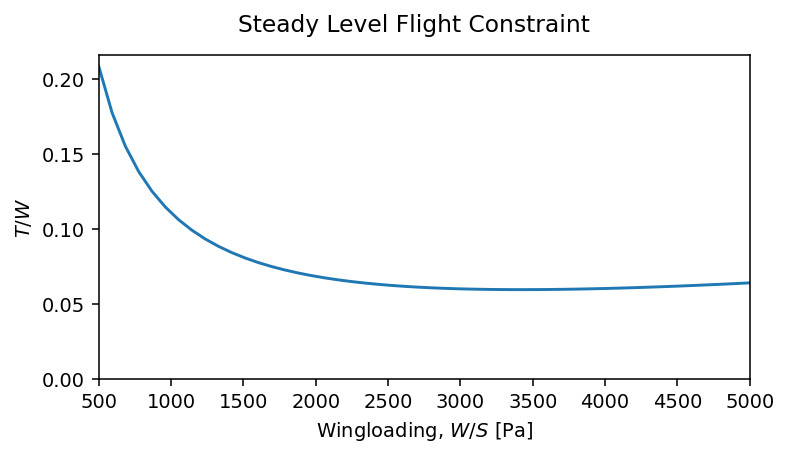

In [17]:
from carpy.utility import cast2numpy

S = sp.symbols("S")

def t2w_helper(loading, sympy_func):
    """Compute T/W for given wing loading"""
    
    loading = cast2numpy(loading)
    output = np.empty(loading.shape, dtype=object)
    
    for i in range(len(output.flat)):
        weight = loading.flat[i] * S
        output.flat[i] = np.float64(sympy_func.subs({"W": weight}))
    
    return output

xs = np.linspace(500, 5000)  # Wing loadings
ys = t2w_helper(xs, sympy_func=objective_function)

# Plot nicely
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, dpi=140, figsize=(6, 3))
fig.suptitle("Steady Level Flight Constraint")

ax.plot(xs, ys)
ax.set_xlabel(r"Wingloading, $W/S$ [Pa]")
ax.set_ylabel(r"$T/W$")
ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(0, None)

plt.show()

This is the instantaneous $T/W$ ratio required at altitude and speed.
In most cases, you'll want to normalise this to the expected fraction of MTOW the constraint applies at, as well as the thrust available after lapse due to altitude and speed.

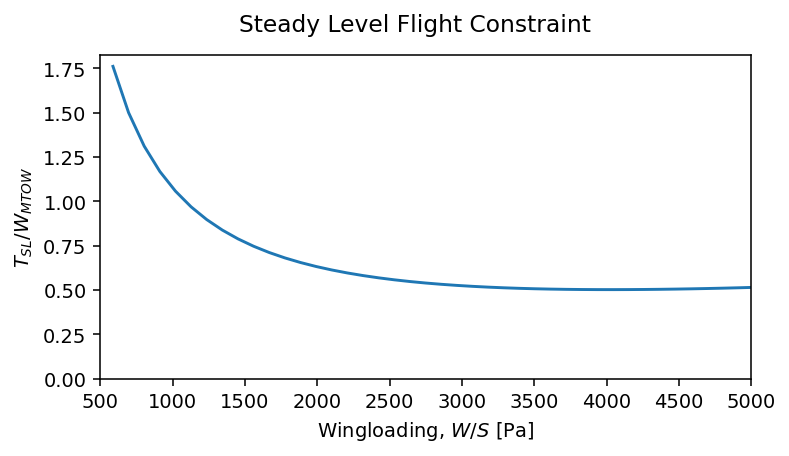

In [18]:
from carpy.propulsion import BasicTurbo

Mach_num = speed / myatmosphere.c_sound(z, geometric=True)
Tlapse = BasicTurbo.TurbofanHiBPR().Tlapse(Mach=Mach_num, altitude=z)
MTOWfrac = 0.85

fig, ax = plt.subplots(1, dpi=140, figsize=(6, 3))
fig.suptitle("Steady Level Flight Constraint")

ax.plot(xs / MTOWfrac, ys / (Tlapse / MTOWfrac))
ax.set_xlabel(r"Wingloading, $W/S$ [Pa]")
ax.set_ylabel(r"$T_{SL}/W_{MTOW}$")
ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(0, None)

plt.show()

***
## 4) `Manoeuvre3DPW(Constraint)` objects

#### Governing Equation

The governing equation takes the thrust to weight expression for manoeuvring flight, which can be used to solve for the thrust to weight requirement of a propulsion system.
By using $P= F \times V$, it is easily demonstrable that the power to weight of that propulsion system is the whole expression multiplied by velocity.

In [19]:
from carpy.conceptualdesign import Manoeuvre3DPW

Manoeuvre3DPW._equation

Eq(P/W, V*((-C_L*S*q/W + sqrt(Vdot_n**2/g**2 + (sqrt(1 - zdot**2/V**2) + (zddot - Vdot*zdot/V)/(g*sqrt(1 - zdot**2/V**2)))**2))/sin(alpha + epsilon) + (C_D*S*q/W + Vdot/g + zdot/V)/cos(alpha + epsilon)))

#### Example Application

Create constraint on design variables based on flight conditions/mission requirements:

In [20]:
from carpy.environment import ISA1975
from carpy.utility import Quantity

# Prescribe flight conditions at the design point (mission requirement)
z = Quantity(8e3, "ft")  # Cruise altitude
speed = Quantity(183, "kt")  # Cruise speed

# Create an atmosphere object, and use it to compute relevant flight conditions
myatmosphere = ISA1975()
dynamic_pressure = 0.5 * myatmosphere.rho(z, geometric=True) * speed ** 2
local_gravity = myatmosphere.g_acc(z)

# Apply the computed dynamic pressure to our energy constraint
mymission = Manoeuvre3DPW(q=dynamic_pressure, g=local_gravity, V=speed)

# Pull the constraint out of the created Constraints object
myconstraint = mymission.constraints[0]

# Show readers what the constraint looks like
myconstraint()

Eq(P/W, 94.1433333333333*(-4267.27473796933*C_L*S/W + sqrt(0.0104141759558442*Vdot_n**2 + (sqrt(1 - 0.000112829030750147*zdot**2) + 0.102049869945259*(-0.010622101051588*Vdot*zdot + zddot)/sqrt(1 - 0.000112829030750147*zdot**2))**2))/sin(alpha + epsilon) + 94.1433333333333*(4267.27473796933*C_D*S/W + 0.102049869945259*Vdot + 0.010622101051588*zdot)/cos(alpha + epsilon))

Looks messy! Let's find the symbols that we're missing so far:

In [21]:
# Tell the user/reader, what are the symbols we have yet to evaluate?
# Call zero arguments to get the current constraint with all possible substitutions made
print(myconstraint().free_symbols)

{S, zddot, Vdot_n, Vdot, C_L, C_D, epsilon, W, alpha, P, zdot}


Amend the constraint to include simplifications to the design and mission requirements using the above variables:

In [22]:
# Decide that we can apply more constraints
myconstraint.Vdot = 0  # The aircraft is not accelerating along the flight path
myconstraint.Vdot_n = 0  # The aircraft is not accelerating for circular motion
myconstraint.zdot = 0  # The aircraft is not climbing
myconstraint.zddot = 0  # The aircraft is not about to start climbing or descending
myconstraint.epsilon = 0  # The aircraft thrust axis aligns with the body longitudinal axis

# Show readers what the constraint looks like
myconstraint()

Eq(P/W, 401735.46808156*C_D*S/(W*cos(alpha)) + 94.1433333333333*(-4267.27473796933*C_L*S/W + 1)/sin(alpha))

Create a simple lift and drag model, a parametric expression based on angle of attack:

In [23]:
import numpy as np
import sympy as sp

def aeromodel(CL):
    kwargs = dict()
    kwargs["CL"] = CL
    
    # 92% flat plate lift curve slope
    kwargs["alpha"] = CL / (2 * np.pi * 0.92)

    # CD = CDmin + k CL^2
    kwargs["CD"] = 0.0254 + (1 / np.pi / 0.781 / 10.12) * kwargs["CL"] ** 2
    
    return kwargs

Make an objective function from the equality:

In [24]:
P, W = sp.symbols("P,W")
q, S, CL, W = sp.symbols("q,S,C_L,W")

# Since we are not in circular motion, L = nW = n * q * S * CL where n ~ 1
n = 1.0
CLestimate = n * W / (q * S)
# If you were sustaining a turn, CLestimate would be the stall-limited max CL

objective_function = sp.solve(myconstraint(**aeromodel(CLestimate)), P/W)[0].simplify()

# Show readers what the P/W expression looks like
objective_function

(10204.0808892716*S**2 + 0.000888500235994538*W**2)/(S*W*cos(4.05398091248933e-5*W/S))

Apply wingloading:

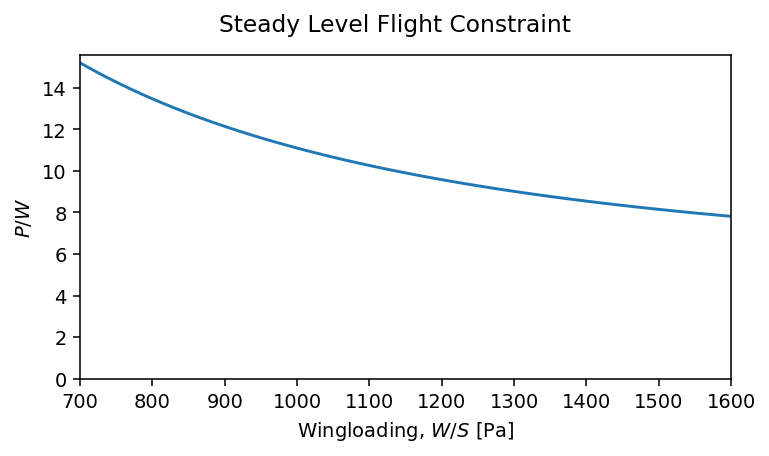

In [25]:
from carpy.utility import cast2numpy

S = sp.symbols("S")

def p2w_helper(loading, sympy_func):
    """Compute P/W for given wing loading"""
    
    loading = cast2numpy(loading)
    output = np.empty(loading.shape, dtype=object)
    
    for i in range(len(output.flat)):
        weight = loading.flat[i] * S
        output.flat[i] = np.float64(sympy_func.subs({"W": weight}))
    
    return output

xs = np.linspace(700, 1600)  # Wing loadings
ys = p2w_helper(xs, sympy_func=objective_function)

# Plot nicely
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, dpi=140, figsize=(6, 3))
fig.suptitle("Steady Level Flight Constraint")

ax.plot(xs, ys)
ax.set_xlabel(r"Wingloading, $W/S$ [Pa]")
ax.set_ylabel(r"$P/W$")
ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(0, None)

plt.show()

This is the instantaneous $P/W$ ratio required at altitude and speed.
In most cases, you'll want to normalise this to the expected fraction of MTOW the constraint applies at, as well as the power available after lapse due to altitude and speed.

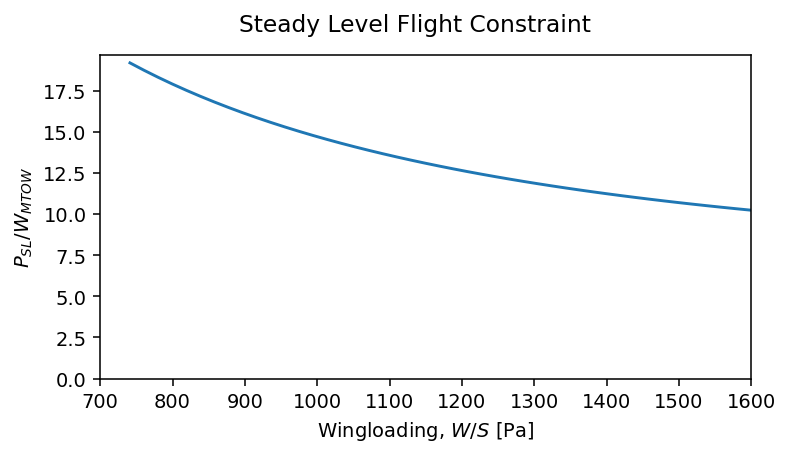

In [26]:
from carpy.propulsion import BasicPiston

Mach_num = speed / myatmosphere.c_sound(z, geometric=True)
Plapse = BasicPiston.PistonNACA925().Plapse(Mach=Mach_num, altitude=z)
MTOW = Quantity(3600, "lb").x * 9.81
MTOWfrac = 3400 / 3600

fig, ax = plt.subplots(1, dpi=140, figsize=(6, 3))
fig.suptitle("Steady Level Flight Constraint")

ax.plot(xs / MTOWfrac, ys / (Plapse / MTOWfrac))
ax.set_xlabel(r"Wingloading, $W/S$ [Pa]")
ax.set_ylabel(r"$P_{SL}/W_{MTOW}$")
ax.set_xlim(xs.min(), xs.max())
ax.set_ylim(0, None)

plt.show()

The example thus far has been constructed around the Cirrus SR-22 aircraft.
Dimensionalise the result and compare to the Cirrus aircraft:

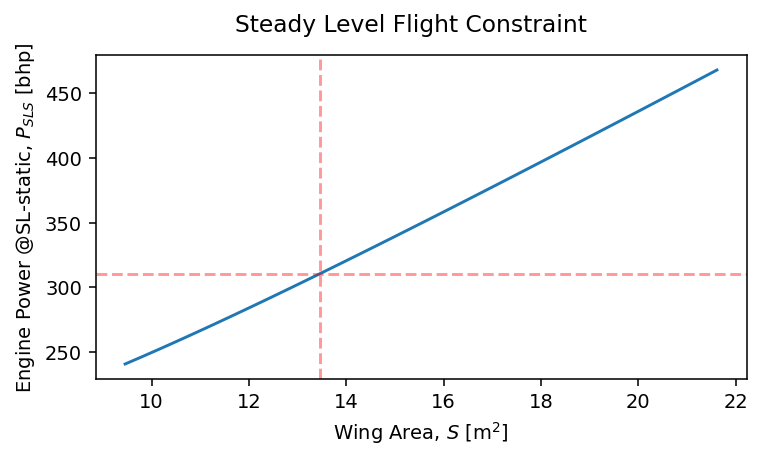

In [27]:
from carpy.propulsion import BasicPiston

Mach_num = speed / myatmosphere.c_sound(z, geometric=True)

# Fraction of engine SL static brake power available for flight power
# Lapse due to altitude
Plapse = BasicPiston.PistonGaggFarrar().Plapse(Mach=Mach_num, altitude=z)
# Lapse due to efficiency of shaft and propeller
Plapse *= 0.87

fig, ax = plt.subplots(1, dpi=140, figsize=(6, 3))
fig.suptitle("Steady Level Flight Constraint")

ax.plot(MTOW / (xs / MTOWfrac), Quantity(ys / (Plapse / MTOWfrac) * MTOW, "W").to("hp"))
ax.set_xlabel(r"Wing Area, $S$ [m$^2$]")
ax.set_ylabel(r"Engine Power @SL-static, $P_{SLS}$ [bhp]")

# Continental IO-550-N 310 bhp, Cirrus SR-22 144.9ft^2
ax.axhline(310, c="r", ls="--", alpha=0.4)
ax.axvline(Quantity(144.9, "ft^{2}"), c="r", ls="--", alpha=0.4)

plt.show()